# Анализ скидок ассортимента ИКЕА по категориям

Цель данного ноутбука попрактиковаться в использовании python для анализа данных с применением библиотек работы с данными и визуализацией pandas и seaborn. Для этого на kaggle был выбран датасет [IKEA Furniture](http://www.kaggle.com/datasets/ahmedkallam/ikea-sa-furniture-web-scraping), в котором представлены товары, их описание, старые и новые цены. 

In [258]:
#Импорт библиотек
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
import numpy as np

Setup Complete


In [287]:
#Импорт датасета
file_path = '/kaggle/input/ikea-sa-furniture-web-scraping/IKEA_SA_Furniture_Web_Scrapings_sss.csv'
df = pd.read_csv(file_path, index_col=0)

Проверка корректности импорта датасета, типов данных в колонках, количества уникальных значений и количества по категориям мебели. 

In [260]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [261]:
df['price'].describe()

count    3694.000000
mean     1078.208419
std      1374.652494
min         3.000000
25%       180.900000
50%       544.700000
75%      1429.500000
max      9585.000000
Name: price, dtype: float64

In [262]:
df.dtypes

item_id                int64
name                  object
category              object
price                float64
old_price             object
sellable_online         bool
link                  object
other_colors          object
short_description     object
designer              object
depth                float64
height               float64
width                float64
dtype: object

In [263]:
df.nunique()

item_id              2962
name                  607
category               17
price                 979
old_price             365
sellable_online         2
link                 2962
other_colors            2
short_description    1706
designer              381
depth                 114
height                193
width                 263
dtype: int64

In [264]:
df['category'].value_counts()

category
Tables & desks                          612
Bookcases & shelving units              548
Chairs                                  481
Sofas & armchairs                       428
Cabinets & cupboards                    292
Wardrobes                               236
Outdoor furniture                       216
Beds                                    208
TV & media furniture                    190
Chests of drawers & drawer units        125
Children's furniture                    124
Nursery furniture                        97
Bar furniture                            47
Trolleys                                 28
Café furniture                           26
Sideboards, buffets & console tables     23
Room dividers                            13
Name: count, dtype: int64

Для работы с колонкой old_price необходимо преобразовать колонку к типу float, приравнять значения "No old price" к текущим ценам, удалить лишние символы. 
На основании получившейся колонки, можно добавить столбцы с определением есть ли скидка на данный товар и на сколько изменилась цена. 

In [288]:
df['old_price'] = df['old_price'].str.replace('SR ', '')
df['old_price'] = df['old_price'].str.replace(',', '')

In [289]:
#Изменение колонки со старыми ценами в числовой формат
def old_price(df):
    if df['old_price'] == 'No old price':
        return(df['price'])
    elif df['old_price'][-4:] == 'pack':
        return(np.nan)
    else:
        return(float(df['old_price']))
       

In [290]:
df['old_price'] = df.apply(old_price, axis=1)

In [291]:
#Добавление колонки с процентным выражением изменения цены
def price_change(df):
    return((df['price'] / df['old_price'] - 1) * 100)
df['price_change, %'] = df.apply(price_change, axis=1).round(2)

In [292]:
#Добавление колонки с определением есть ли скидка
def discount(df):
    if df['price_change, %'] == 0:
        return('No')
    else:
        return('Yes')
df['discount'] = df.apply(discount, axis=1)

In [293]:
#Проверка измененных и добавленных колонок
df[['price', 'old_price', 'price_change, %', 'discount']].head(15)

,price,old_price,"price_change, %",discount
0,265.0,265.0,0.00,No
1,995.0,995.0,0.00,No
2,2095.0,2095.0,0.00,No
3,69.0,69.0,0.00,No
4,225.0,225.0,0.00,No
5,345.0,345.0,0.00,No
6,129.0,129.0,0.00,No
7,195.0,195.0,0.00,No
8,129.0,129.0,0.00,No
9,2176.0,2375.0,-8.38,Yes


Для анализа ассортимента со скидками будут построены следующие диаграммы:
- Гистограмма с распределением всего ассортимента по наличию скидки,
- Гистограмма по категориям с количеством товара со скидками и без,
- Гистограмма товаров со скидкой по категориям по наличию дополнительных цветов в ассортименте
- Тепловые карты со средним процентом скидки и так же минимальной и максимальной скидки

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x400 with 0 Axes>

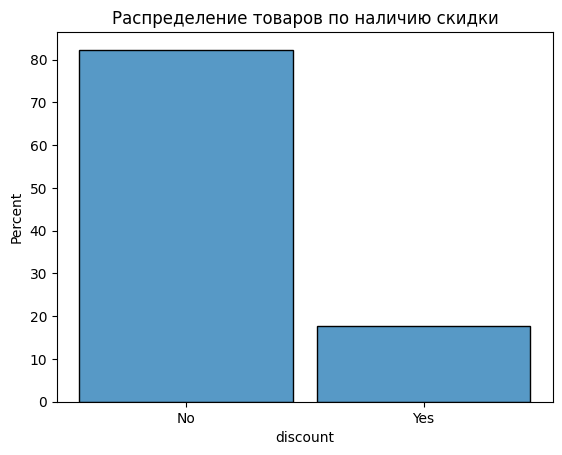

<Figure size 800x400 with 0 Axes>

In [294]:
plt.title('Распределение товаров по наличию скидки')
sns.histplot(data=df, x='discount', stat='percent', shrink=.9)
plt.figure(figsize=(8, 4))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: title={'center': 'Распределение товаров по наличию скидки по категориям'}, xlabel='Count', ylabel='category'>

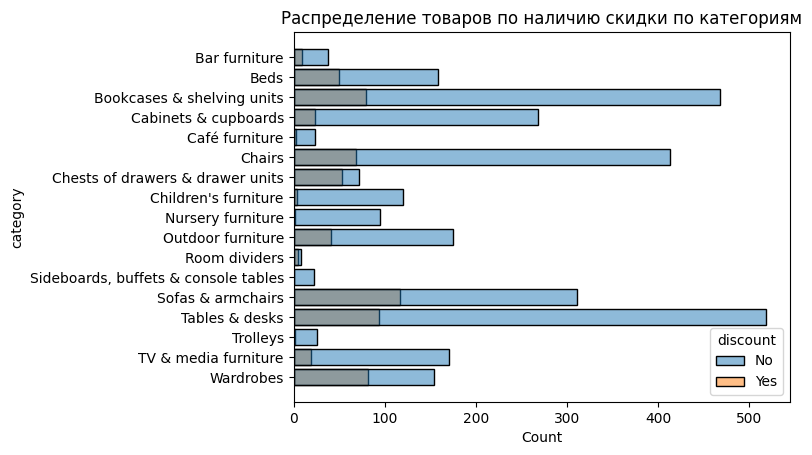

In [295]:
plt.title('Распределение товаров по наличию скидки по категориям')
sns.histplot(data=df, y='category', hue='discount', shrink=.8, stat='count')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: title={'center': 'Наличие другого цвета у товаров со скидкой'}, xlabel='Count', ylabel='category'>

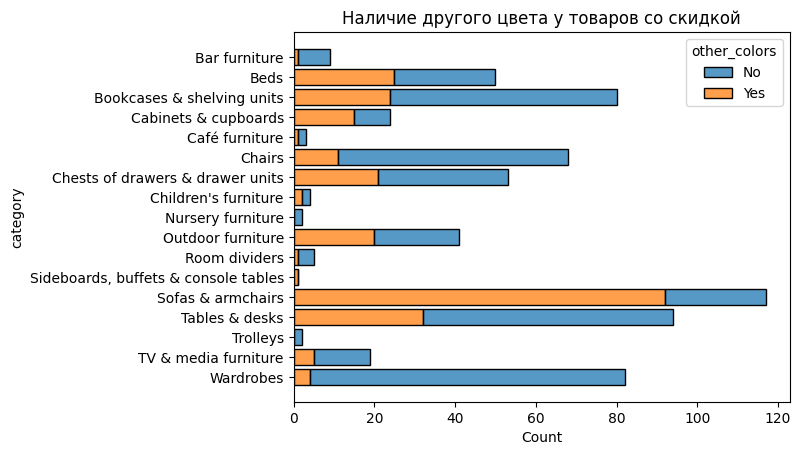

In [296]:
plt.title('Наличие другого цвета у товаров со скидкой')
sns.histplot(data=df[df['price_change, %'] != 0] , y='category', hue='other_colors', shrink=.8, stat='count',  multiple="stack")

In [297]:
#Группировка товаров по категориям и агрегирование по среднему, максимальному и минимальному значению скидки
category_discount = df[df['price_change, %'] != 0].groupby('category').agg({'price_change, %': ['mean', 'max', 'min']})
category_discount

price_change, %             
                                                mean    max   min
category                                                         
Bar furniture                             -15.836667  -8.38 -40.0
Beds                                      -16.132667  -2.11 -40.0
Bookcases & shelving units                -18.425316  -0.15 -40.0
Cabinets & cupboards                      -19.237083  -3.00 -40.0
Café furniture                            -20.000000 -20.00 -20.0
Chairs                                    -17.086029  -0.38 -40.0
Chests of drawers & drawer units          -19.161887  -2.17 -30.0
Children's furniture                      -18.317500 -13.27 -20.0
Nursery furniture                         -20.000000 -20.00 -20.0
Outdoor furniture                         -25.233000  -8.77 -40.0
Room dividers                             -23.670000 -18.52 -40.0
Sideboards, buffets & console tables      -20.000000 -20.00 -20.0
Sofas & armchairs                         -19.810088  -1.36 -40.0
TV & media furniture                      -13.464737  -0.83 -40.0
Tables & desks                            -16.668085  -2.62 -40.0
Trolleys                                  -35.000000 -30.00 -40.0
Wardrobes                                 -18.111951  -0.17 -50.0

Text(0.5, 23.38159722222222, 'Средняя скидка')

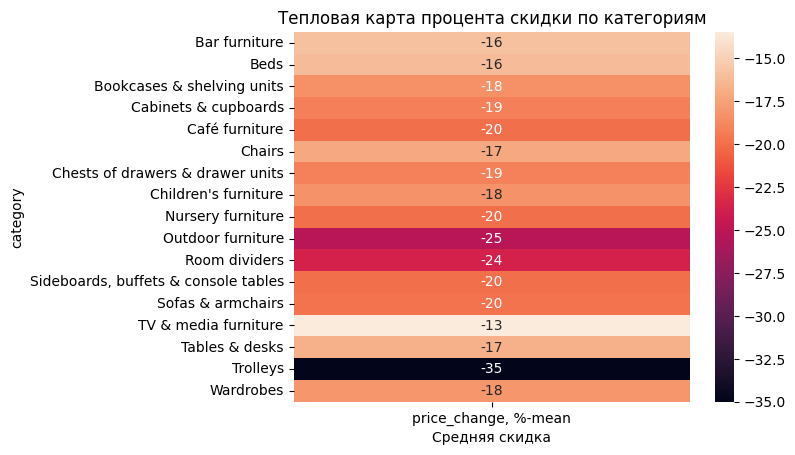

In [298]:
plt.title('Тепловая карта процента скидки по категориям')
sns.heatmap(category_discount.iloc[:, 0:1], annot=True)
plt.xlabel('Средняя скидка')

Text(0.5, 23.38159722222222, 'Средняя, максимальная и минимальная скидки')

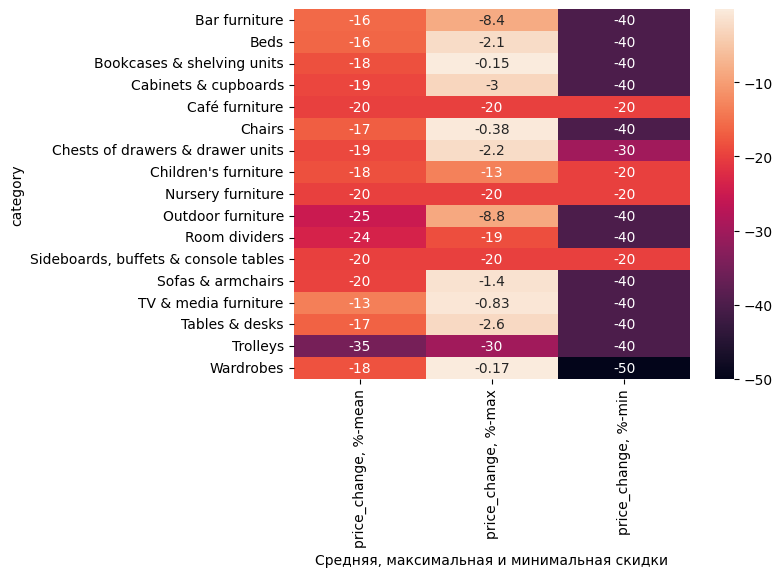

In [299]:
sns.heatmap(category_discount, annot=True)
plt.xlabel('Средняя, максимальная и минимальная скидки')